<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/beras_kualitas_medium2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f77ce1cca90>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.beras_kualitas_medium_ii.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


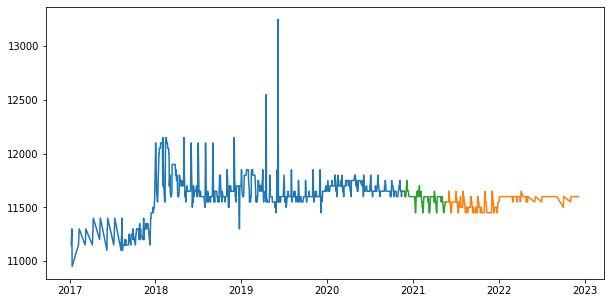

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

## model 

In [10]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


### SGD

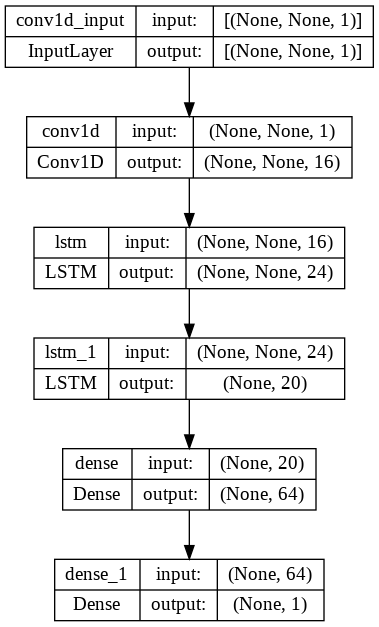

In [ ]:
plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [11]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 16s 82ms/step - loss: 0.0920 - mae: 0.3019 - mape: 94.5614 - val_loss: 0.1473 - val_mae: 0.3538 - val_mape: 4599740.0000
Epoch 2/30
44/44 [==============================] - 1s 26ms/step - loss: 0.0631 - mae: 0.2496 - mape: 78.0891 - val_loss: 0.1155 - val_mae: 0.3148 - val_mape: 9958401.0000
Epoch 3/30
44/44 [==============================] - 1s 23ms/step - loss: 0.0429 - mae: 0.2054 - mape: 64.2222 - val_loss: 0.0934 - val_mae: 0.2832 - val_mape: 14331862.0000
Epoch 4/30
44/44 [==============================] - 1s 25ms/step - loss: 0.0293 - mae: 0.1695 - mape: 52.8969 - val_loss: 0.0777 - val_mae: 0.2574 - val_mape: 17902994.0000
Epoch 5/30
44/44 [==============================] - 1s 30ms/step - loss: 0.0202 - mae: 0.1402 - mape: 43.6798 - val_loss: 0.0665 - val_mae: 0.2391 - val_mape: 20816848.0000
Epoch 6/30
44/44 [==============================] - 1s 30ms/step - loss: 0.0140 - mae: 0.1159 - mape: 36.0278 - val_loss: 0.0584 - val_m

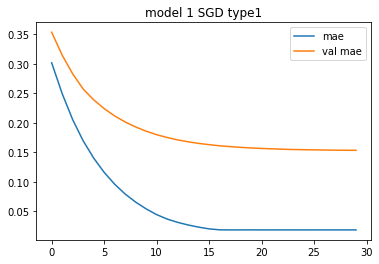

In [12]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

In [13]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
test_beras_ = scal_range.fit_transform(forecast.reshape(-1, 1))

131/131 [==============================] - 2s 11ms/step
132.47348 1.1506497 144.97278165874792


,date,actual,prediction
0,2021-05-20,11550,11679.336914
1,2021-05-21,11550,11679.000977
2,2021-05-24,11550,11679.223633
3,2021-05-25,11550,11678.752930
4,2021-05-27,11550,11678.885742
...,...,...,...
229,2022-11-02,11600,11675.147461
230,2022-11-03,11600,11675.247070
231,2022-11-04,11600,11675.090820
232,2022-12-01,11600,11675.210938


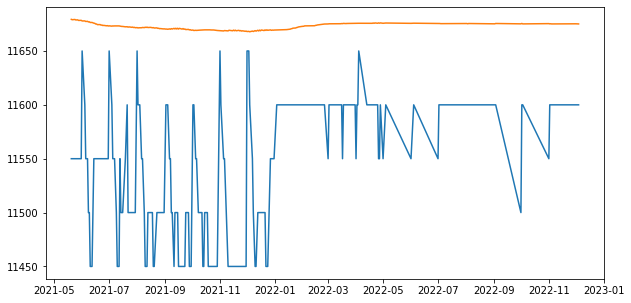

In [14]:
prediction = forecast_predict(model, test_beras_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_beras = pd.DataFrame()
data_new_beras['date'] = y_test
data_new_beras['actual'] = x_test
data_new_beras['prediction'] = data_result
data_new_beras.to_csv('beras_medium2_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_beras.date, data_new_beras.actual)
plt.plot(data_new_beras.date, data_new_beras.prediction)
data_new_beras

#### type2

In [15]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0037 - mae: 0.0406 - mape: 12.2175 - val_loss: 0.0337 - val_mae: 0.1557 - val_mape: 34243880.0000
Epoch 2/30
718/718 [==============================] - 9s 12ms/step - loss: 0.0037 - mae: 0.0403 - mape: 12.0437 - val_loss: 0.0336 - val_mae: 0.1552 - val_mape: 34356132.0000
Epoch 3/30
718/718 [==============================] - 8s 11ms/step - loss: 0.0037 - mae: 0.0401 - mape: 11.9938 - val_loss: 0.0335 - val_mae: 0.1546 - val_mape: 34471776.0000
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0037 - mae: 0.0404 - mape: 12.0865 - val_loss: 0.0334 - val_mae: 0.1542 - val_mape: 34541780.0000
Epoch 5/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0037 - mae: 0.0403 - mape: 12.0655 - val_loss: 0.0336 - val_mae: 0.1548 - val_mape: 34446676.0000
Epoch 6/30
718/718 [==============================] - 7s 10ms/step - loss: 0.0037 - mae: 0.0399 - mape: 11.8961 - val_loss: 0.03

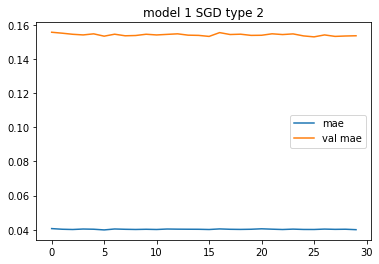

In [16]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
124.00047 1.0772216 137.2452754195932


,date,actual,prediction
0,2021-05-20,11550,11679.336914
1,2021-05-21,11550,11679.000977
2,2021-05-24,11550,11679.223633
3,2021-05-25,11550,11678.752930
4,2021-05-27,11550,11678.885742
...,...,...,...
229,2022-11-02,11600,11675.147461
230,2022-11-03,11600,11675.247070
231,2022-11-04,11600,11675.090820
232,2022-12-01,11600,11675.210938


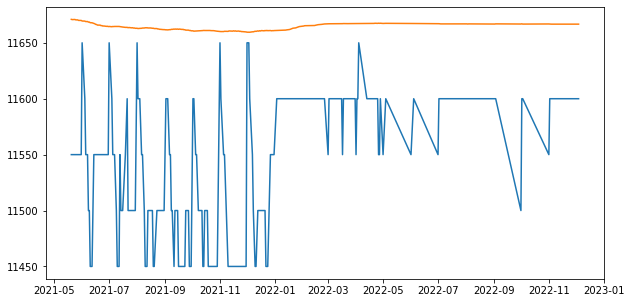

In [17]:
win_size1 = 60
test_beras_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_beras_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_beras_1 = pd.DataFrame()
data_new_beras_1['actual'] = x_test
data_new_beras_1['prediction'] = data_result_1
data_new_beras_1.to_csv('beras_medium2_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_1.actual)
plt.plot(y_test, data_new_beras_1.prediction)
data_new_beras

#### type3

In [18]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0024 - mae: 0.0283 - mape: 8.9660 - val_loss: 0.0336 - val_mae: 0.1547 - val_mape: 34495844.0000
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0277 - mape: 8.7387 - val_loss: 0.0338 - val_mae: 0.1559 - val_mape: 34308780.0000
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0272 - mape: 8.5192 - val_loss: 0.0340 - val_mae: 0.1568 - val_mape: 34168664.0000
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0267 - mape: 8.3152 - val_loss: 0.0341 - val_mae: 0.1572 - val_mape: 34108104.0000
Epoch 5/30
84/84 [==============================] - 2s 17ms/step - loss: 0.0024 - mae: 0.0267 - mape: 8.3232 - val_loss: 0.0341 - val_mae: 0.1572 - val_mape: 34098828.0000
Epoch 6/30
84/84 [==============================] - 3s 29ms/step - loss: 0.0024 - mae: 0.0266 - mape: 8.2989 - val_loss: 0.0341 - val_mae: 0

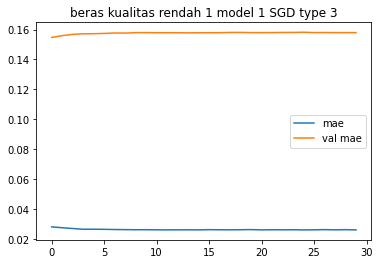

In [19]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('beras kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 6ms/step
109.62199 0.9526099 124.28809385229745


,actual,prediction
0,11550,11656.430664
1,11550,11656.127930
2,11550,11656.315430
3,11550,11655.873047
4,11550,11655.958984
...,...,...
229,11600,11652.207031
230,11600,11652.210938
231,11600,11652.129883
232,11600,11652.175781


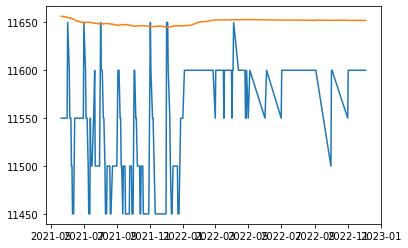

In [20]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_beras_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_beras_2 = pd.DataFrame()
# data_new_beras1['date'] = date_test
data_new_beras_2['actual'] = x_test
data_new_beras_2['prediction'] = data_result_2
data_new_beras_2.to_csv('beras_medium2_model1_sgd_type3')

plt.plot(y_test, data_new_beras_2.actual)
plt.plot(y_test, data_new_beras_2.prediction)
data_new_beras_2

### Adam

In [21]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [22]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 7s 64ms/step - loss: 0.0899 - mae: 0.2986 - mape: 93.5664 - val_loss: 0.1430 - val_mae: 0.3488 - val_mape: 5436474.0000
Epoch 2/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0575 - mae: 0.2372 - mape: 74.1402 - val_loss: 0.0876 - val_mae: 0.2740 - val_mape: 15911625.0000
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0138 - mae: 0.0988 - mape: 30.4736 - val_loss: 0.0300 - val_mae: 0.1424 - val_mape: 39489632.0000
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 5.4744e-04 - mae: 0.0185 - mape: 5.8170 - val_loss: 0.0305 - val_mae: 0.1435 - val_mape: 38556880.0000
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 4.5974e-04 - mae: 0.0173 - mape: 5.4115 - val_loss: 0.0309 - val_mae: 0.1441 - val_mape: 38044316.0000
Epoch 6/30
44/44 [==============================] - 1s 21ms/step - loss: 4.9401e-04 - mae: 0.0182 - mape: 5.6744 - val_loss: 0.030

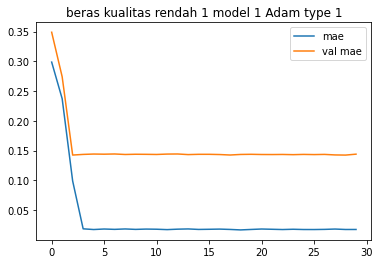

In [23]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('beras kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
74.67331 0.649228 90.1298352768452


,actual,prediction
0,11550,11656.498047
1,11550,11658.414062
2,11550,11655.062500
3,11550,11656.811523
4,11550,11653.073242
...,...,...
229,11600,11629.298828
230,11600,11628.997070
231,11600,11629.284180
232,11600,11629.009766


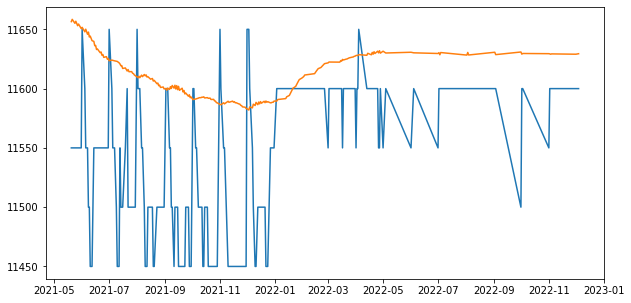

In [24]:
prediction_a = forecast_predict(model_a, test_beras_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_beras_a = pd.DataFrame()
# data_new_beras1['date'] = date_test
data_new_beras_a['actual'] = x_test
data_new_beras_a['prediction'] = data_result_a
data_new_beras_a.to_csv('beras_medium2_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_beras_a.actual)
plt.plot(y_test, data_new_beras_a.prediction)
data_new_beras_a

#### Type 2

In [86]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0031 - mae: 0.0336 - mape: 10.0943 - val_loss: 0.0333 - val_mae: 0.1508 - val_mape: 36215844.0000
Epoch 2/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0030 - mae: 0.0332 - mape: 9.9712 - val_loss: 0.0317 - val_mae: 0.1459 - val_mape: 37739976.0000
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0031 - mae: 0.0336 - mape: 10.1201 - val_loss: 0.0315 - val_mae: 0.1456 - val_mape: 37875192.0000
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0031 - mae: 0.0338 - mape: 10.1286 - val_loss: 0.0309 - val_mae: 0.1445 - val_mape: 38686604.0000
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0030 - mae: 0.0331 - mape: 9.9446 - val_loss: 0.0315 - val_mae: 0.1456 - val_mape: 37855816.0000
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0030 - mae: 0.0335 - mape: 10.0384 - val_loss: 0.0317 - 

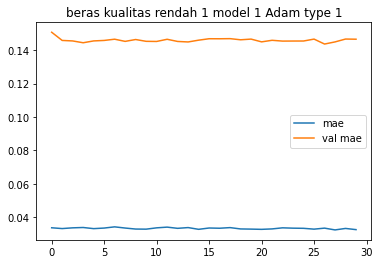

In [87]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('beras kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
116.48463 1.0116229 127.05824590148606


,actual,prediction
0,11550,11683.241211
1,11550,11685.477539
2,11550,11681.000000
3,11550,11682.542969
4,11550,11677.832031
...,...,...
229,11600,11665.697266
230,11600,11664.738281
231,11600,11665.454102
232,11600,11664.863281


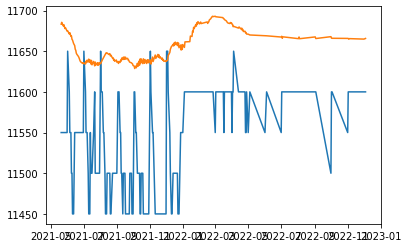

In [88]:
prediction_a1 = forecast_predict(model_a, test_beras_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_beras_a1 = pd.DataFrame()
data_new_beras_a1['actual'] = x_test
data_new_beras_a1['prediction'] = data_result_a1
data_new_beras_a1.to_csv('beras_medium2_model1_adam_type2.csv')

plt.plot(y_test, data_new_beras_a1.actual)
plt.plot(y_test, data_new_beras_a1.prediction)
data_new_beras_a1

#### Type 3

In [89]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0023 - mae: 0.0227 - mape: 6.8780 - val_loss: 0.0310 - val_mae: 0.1444 - val_mape: 38435112.0000
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0023 - mae: 0.0228 - mape: 6.9437 - val_loss: 0.0306 - val_mae: 0.1437 - val_mape: 39025316.0000
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0023 - mae: 0.0232 - mape: 7.1698 - val_loss: 0.0314 - val_mae: 0.1451 - val_mape: 37892032.0000
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0023 - mae: 0.0223 - mape: 6.7523 - val_loss: 0.0310 - val_mae: 0.1445 - val_mape: 38371064.0000
Epoch 5/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0023 - mae: 0.0223 - mape: 6.7809 - val_loss: 0.0308 - val_mae: 0.1441 - val_mape: 38717344.0000
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0023 - mae: 0.0230 - mape: 7.0699 - val_loss: 0.0314 - val_mae: 0

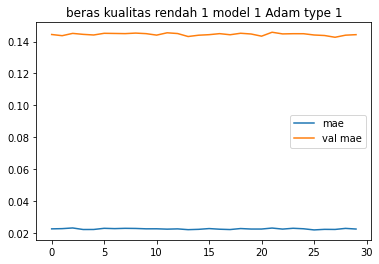

In [90]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('beras kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
88.9313 0.77246755 100.08974488552761


,actual,prediction
0,11550,11653.151367
1,11550,11655.577148
2,11550,11651.073242
3,11550,11653.156250
4,11550,11648.118164
...,...,...
229,11600,11635.334961
230,11600,11634.153320
231,11600,11634.084961
232,11600,11633.206055


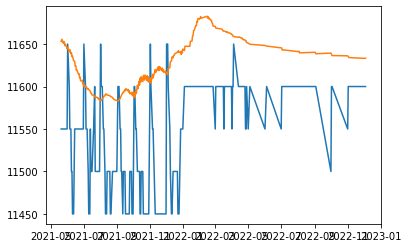

In [91]:
prediction_a2 = forecast_predict(model_a, test_beras_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_beras_a2 = pd.DataFrame()
# data_new_beras1['date'] = date_test
data_new_beras_a2['actual'] = x_test
data_new_beras_a2['prediction'] = data_result_a2
data_new_beras_a2.to_csv('beras_medium2_model1_adam_type3.csv')

plt.plot(y_test, data_new_beras_a2.actual)
plt.plot(y_test, data_new_beras_a2.prediction)
data_new_beras_a2

## model 1

### Adam

In [74]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
        LSTM(128, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_12 (LSTM)              (None, None, 128)         74240     
                                                                 
 lstm_13 (LSTM)              (None, 32)                20608     
                                                                 
 dense_16 (Dense)            (None, 64)                2112      
                                                                 
 dense_17 (Dense)            (None, 128)               8320      
                                                                 
 dense_18 (Dense)            (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [75]:
history1 = model1.fit(train_step, epochs=100, validation_data=val_step)

Epoch 1/100
44/44 [==============================] - 5s 41ms/step - loss: 0.0086 - mae: 0.0574 - mape: 17.7326 - val_loss: 0.0301 - val_mae: 0.1424 - val_mape: 39515440.0000
Epoch 2/100
44/44 [==============================] - 1s 21ms/step - loss: 5.0844e-04 - mae: 0.0183 - mape: 5.6876 - val_loss: 0.0315 - val_mae: 0.1450 - val_mape: 37420288.0000
Epoch 3/100
44/44 [==============================] - 1s 21ms/step - loss: 6.3841e-04 - mae: 0.0201 - mape: 6.2524 - val_loss: 0.0311 - val_mae: 0.1443 - val_mape: 37999028.0000
Epoch 4/100
44/44 [==============================] - 1s 21ms/step - loss: 4.8394e-04 - mae: 0.0179 - mape: 5.5931 - val_loss: 0.0305 - val_mae: 0.1433 - val_mape: 38818240.0000
Epoch 5/100
44/44 [==============================] - 1s 21ms/step - loss: 4.9132e-04 - mae: 0.0177 - mape: 5.5159 - val_loss: 0.0304 - val_mae: 0.1431 - val_mape: 39021740.0000
Epoch 6/100
44/44 [==============================] - 1s 21ms/step - loss: 6.1055e-04 - mae: 0.0194 - mape: 6.0572 - va

17/17 [==============================] - 0s 7ms/step - loss: 0.1546 - mae: 0.3802 - mape: 52.4723


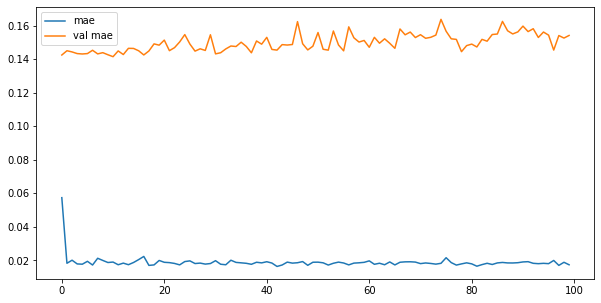

In [76]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [77]:
prediction1 = forecast_predict(model1, test_beras_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_beras1 = pd.DataFrame()
data_new_beras1['actual'] = x_test
data_new_beras1['prediction'] = data_result1
data_new_beras1.to_csv('beras_medium2_model2_adam_type1.csv')

data_new_beras1

191/191 [==============================] - 1s 4ms/step
127.96111 1.111555 140.92673877985328


,actual,prediction
0,11550,11672.341797
1,11550,11673.020508
2,11550,11672.309570
3,11550,11672.852539
4,11550,11671.930664
...,...,...
229,11600,11670.069336
230,11600,11669.392578
231,11600,11669.949219
232,11600,11669.496094


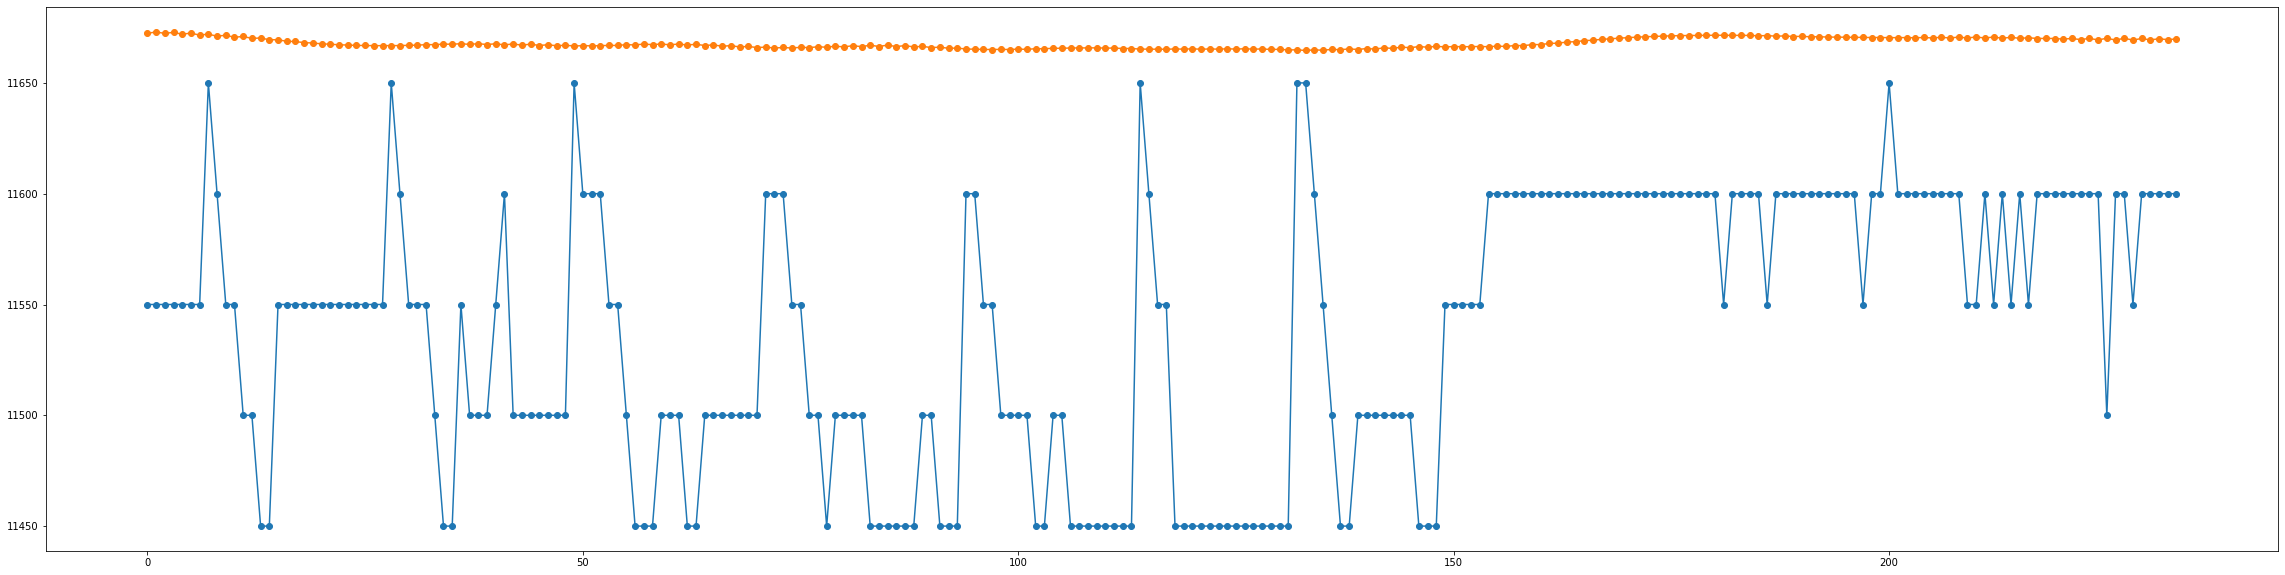

In [78]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_beras1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_beras1['prediction'], '-o')

#### Type 2

In [80]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0036 - mae: 0.0397 - mape: 11.9154 - val_loss: 0.0343 - val_mae: 0.1588 - val_mape: 33689496.0000
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0037 - mae: 0.0401 - mape: 12.0362 - val_loss: 0.0335 - val_mae: 0.1551 - val_mape: 34286652.0000
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0038 - mae: 0.0401 - mape: 12.0255 - val_loss: 0.0350 - val_mae: 0.1616 - val_mape: 33242582.0000
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0037 - mae: 0.0398 - mape: 11.9146 - val_loss: 0.0347 - val_mae: 0.1603 - val_mape: 33443626.0000
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0037 - mae: 0.0398 - mape: 11.9557 - val_loss: 0.0346 - val_mae: 0.1599 - val_mape: 33514178.0000
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0037 - mae: 0.0400 - mape: 12.0101 - val_loss: 0.0340 

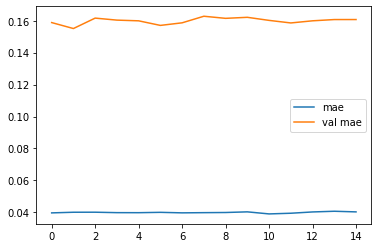

In [81]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
120.35035 1.0456569 140.92673877985328


,actual,prediction
0,11550,11660.307617
1,11550,11660.307617
2,11550,11660.307617
3,11550,11660.307617
4,11550,11660.307617
...,...,...
229,11600,11660.307617
230,11600,11660.307617
231,11600,11660.307617
232,11600,11660.307617


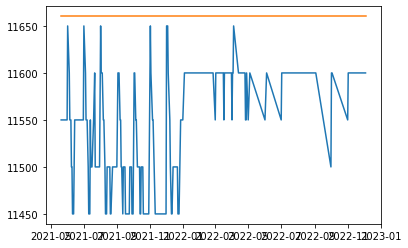

In [82]:
prediction1_1 = forecast_predict(model1, test_beras_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_beras1_1 = pd.DataFrame()
data_new_beras1_1['actual'] = x_test
data_new_beras1_1['prediction'] = data_result1_1
data_new_beras1_1.to_csv('beras_medium2_model2_adam_type2.csv')

plt.plot(y_test, data_new_beras1_1.actual)
plt.plot(y_test, data_new_beras1_1.prediction)
data_new_beras1_1

#### Type 3

In [83]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0024 - mae: 0.0270 - mape: 8.3816 - val_loss: 0.0339 - val_mae: 0.1568 - val_mape: 34015836.0000
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0025 - mae: 0.0271 - mape: 8.4357 - val_loss: 0.0350 - val_mae: 0.1615 - val_mape: 33256486.0000
Epoch 3/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0025 - mae: 0.0277 - mape: 8.6847 - val_loss: 0.0357 - val_mae: 0.1643 - val_mape: 32806310.0000
Epoch 4/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0025 - mae: 0.0273 - mape: 8.4861 - val_loss: 0.0358 - val_mae: 0.1649 - val_mape: 32710304.0000
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0025 - mae: 0.0267 - mape: 8.2640 - val_loss: 0.0353 - val_mae: 0.1628 - val_mape: 33052208.0000
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0025 - mae: 0.0278 - mape: 8.6871 - val_loss: 0.0362 - val_mae: 0

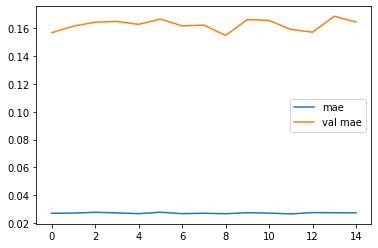

In [84]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
107.69231 0.9359529 140.92673877985328


,actual,prediction
0,11550,11647.5
1,11550,11647.5
2,11550,11647.5
3,11550,11647.5
4,11550,11647.5
...,...,...
229,11600,11647.5
230,11600,11647.5
231,11600,11647.5
232,11600,11647.5


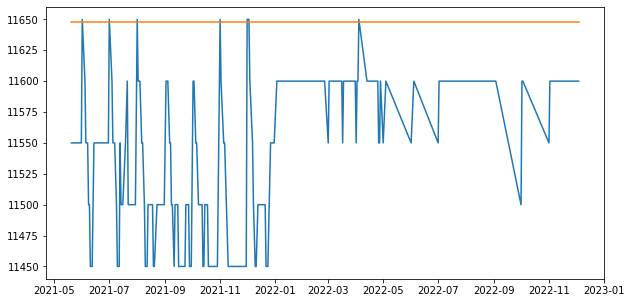

In [85]:
prediction1_2 = forecast_predict(model1, test_beras_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_beras1_2 = pd.DataFrame()
data_new_beras1_2['actual'] = x_test
data_new_beras1_2['prediction'] = data_result1_2
data_new_beras1_2.to_csv('beras_medium2_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras1_2.actual)
plt.plot(y_test, data_new_beras1_2.prediction)

data_new_beras1_2

### SGD

In [42]:
model1_a= Sequential([
    # tf.keras.layers.Conv1D(97, kernel_size=5, 
    #                                        activation='relu',strides=2,
    #                                        input_shape=[None, 1]),
    #                 LSTM(24, return_sequences=True),
    #                 LSTM(64),
    #                 Dense(50, activation='relu'),
    #                 Dense(12, activation='relu'),
    #                 Dense(1)
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
        LSTM(128, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.8), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [43]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [44]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 43ms/step - loss: 0.0893 - mae: 0.2977 - mape: 93.3021 - val_loss: 0.1487 - val_mae: 0.3554 - val_mape: 4467608.0000
Epoch 2/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0708 - mae: 0.2649 - mape: 82.9487 - val_loss: 0.1284 - val_mae: 0.3314 - val_mape: 7818548.0000
Epoch 3/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0566 - mae: 0.2367 - mape: 74.0720 - val_loss: 0.1124 - val_mae: 0.3106 - val_mape: 10679170.0000
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0455 - mae: 0.2119 - mape: 66.2770 - val_loss: 0.0994 - val_mae: 0.2922 - val_mape: 13217418.0000
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0367 - mae: 0.1903 - mape: 59.4620 - val_loss: 0.0888 - val_mae: 0.2760 - val_mape: 15456680.0000
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0297 - mae: 0.1709 - mape: 53.3596 - val_loss: 0.0801 - val_ma

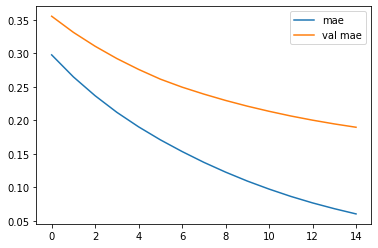

In [45]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 1s 8ms/step
100.61165 0.8745564 116.74790047630407


,actual,prediction
0,11550,11639.96875
1,11550,11639.96875
2,11550,11639.96875
3,11550,11639.96875
4,11550,11639.96875
...,...,...
229,11600,11639.96875
230,11600,11639.96875
231,11600,11639.96875
232,11600,11639.96875


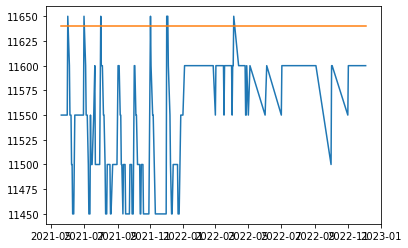

In [46]:
prediction1_a = forecast_predict(model1, test_beras_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_beras1_a = pd.DataFrame()
data_new_beras1_a['actual'] = x_test
data_new_beras1_a['prediction'] = data_result1_a
data_new_beras1_a.to_csv('beras_medium2_model2_sgd_type1.csv')


plt.plot(y_test, data_new_beras1_a.actual)
plt.plot(y_test, data_new_beras1_a.prediction)

data_new_beras1_a

#### Type 2


In [47]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0046 - mae: 0.0395 - mape: 10.8841 - val_loss: 0.0342 - val_mae: 0.1578 - val_mape: 33988444.0000
Epoch 2/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0037 - mae: 0.0394 - mape: 11.6217 - val_loss: 0.0332 - val_mae: 0.1527 - val_mape: 34818056.0000
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0037 - mae: 0.0401 - mape: 11.9723 - val_loss: 0.0331 - val_mae: 0.1523 - val_mape: 34916504.0000
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0037 - mae: 0.0402 - mape: 12.0247 - val_loss: 0.0331 - val_mae: 0.1524 - val_mape: 34910388.0000
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0037 - mae: 0.0401 - mape: 11.9582 - val_loss: 0.0331 - val_mae: 0.1519 - val_mape: 34990036.0000
Epoch 6/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0037 - mae: 0.0400 - mape: 11.9798 - val_loss: 0.033

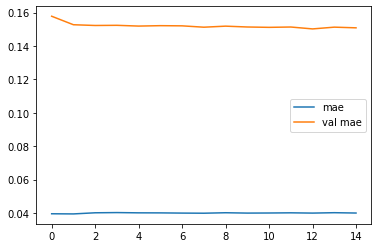

In [48]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
120.55055 1.0473021 133.9412403234157


,actual,prediction
0,11550,11670.828125
1,11550,11670.795898
2,11550,11670.649414
3,11550,11670.540039
4,11550,11670.128906
...,...,...
229,11600,11664.454102
230,11600,11664.644531
231,11600,11664.500000
232,11600,11664.470703


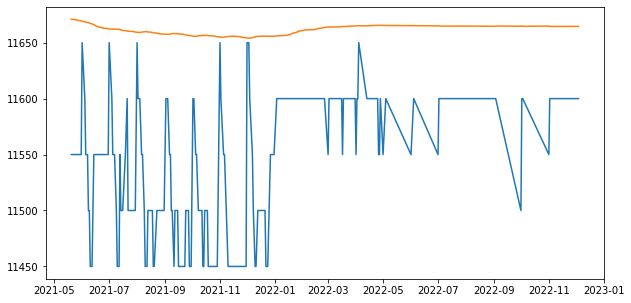

In [49]:
prediction1_a1 = forecast_predict(model1_a, test_beras_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_beras1_a1 = pd.DataFrame()
data_new_beras1_a1['actual'] = x_test
data_new_beras1_a1['prediction'] = data_result1_a1
data_new_beras1_a1.to_csv('beras_medium2_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras1_a1.actual)
plt.plot(y_test, data_new_beras1_a1.prediction)
data_new_beras1_a1

#### Type 3

In [50]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0024 - mae: 0.0282 - mape: 8.9480 - val_loss: 0.0331 - val_mae: 0.1519 - val_mape: 35026660.0000
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0024 - mae: 0.0277 - mape: 8.7519 - val_loss: 0.0332 - val_mae: 0.1528 - val_mape: 34887232.0000
Epoch 3/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0273 - mape: 8.5944 - val_loss: 0.0334 - val_mae: 0.1535 - val_mape: 34777408.0000
Epoch 4/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0271 - mape: 8.4924 - val_loss: 0.0334 - val_mae: 0.1538 - val_mape: 34726900.0000
Epoch 5/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0269 - mape: 8.4226 - val_loss: 0.0335 - val_mae: 0.1541 - val_mape: 34667152.0000
Epoch 6/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0269 - mape: 8.3955 - val_loss: 0.0336 - val_mae: 0

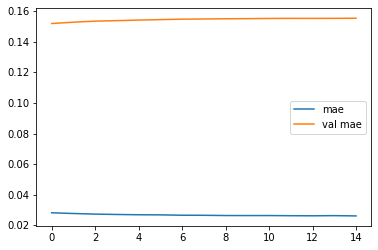

In [51]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
106.32113 0.92396665 121.01171818257933


,actual,prediction
0,11550,11656.233398
1,11550,11656.202148
2,11550,11656.055664
3,11550,11655.949219
4,11550,11655.534180
...,...,...
229,11600,11649.918945
230,11600,11650.111328
231,11600,11649.953125
232,11600,11649.938477


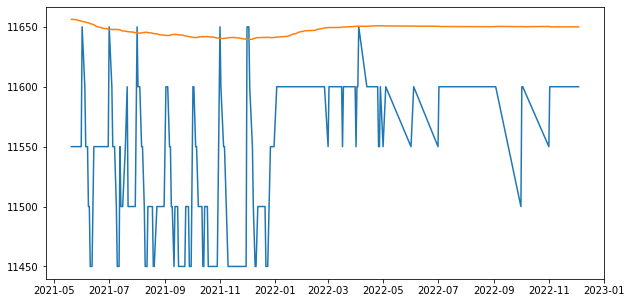

In [52]:
prediction1_a2 = forecast_predict(model1_a, test_beras_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_beras1_a2 = pd.DataFrame()
data_new_beras1_a2['actual'] = x_test
data_new_beras1_a2['prediction'] = data_result1_a2
data_new_beras1_a2.to_csv('beras_medium2_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras1_a2.actual)
plt.plot(y_test, data_new_beras1_a2.prediction)

data_new_beras1_a2

## model 2

### SGD

In [53]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9), loss='mean_squared_error', metrics=['mae'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [54]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [55]:
history2 = model2.fit(train_step, epochs=100, validation_data=val_step)

Epoch 1/100
44/44 [==============================] - 4s 33ms/step - loss: 0.1012 - mae: 0.3174 - val_loss: 0.1780 - val_mae: 0.3867
Epoch 2/100
44/44 [==============================] - 1s 16ms/step - loss: 0.1012 - mae: 0.3174 - val_loss: 0.1779 - val_mae: 0.3866
Epoch 3/100
44/44 [==============================] - 1s 14ms/step - loss: 0.1011 - mae: 0.3173 - val_loss: 0.1779 - val_mae: 0.3866
Epoch 4/100
44/44 [==============================] - 1s 14ms/step - loss: 0.1011 - mae: 0.3173 - val_loss: 0.1778 - val_mae: 0.3865
Epoch 5/100
44/44 [==============================] - 1s 14ms/step - loss: 0.1010 - mae: 0.3171 - val_loss: 0.1778 - val_mae: 0.3865
Epoch 6/100
44/44 [==============================] - 1s 14ms/step - loss: 0.1010 - mae: 0.3171 - val_loss: 0.1777 - val_mae: 0.3864
Epoch 7/100
44/44 [==============================] - 1s 15ms/step - loss: 0.1010 - mae: 0.3170 - val_loss: 0.1777 - val_mae: 0.3864
Epoch 8/100
44/44 [==============================] - 1s 14ms/step - loss: 0.

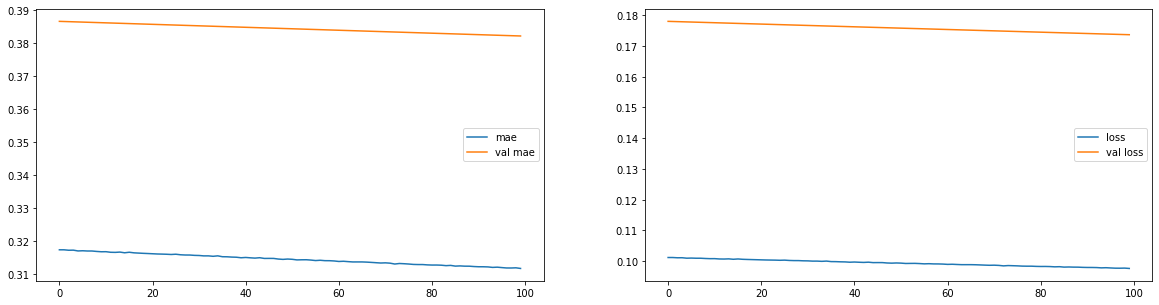

In [56]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 2s 6ms/step
574.14215 4.9726653 577.2852955861599


,actual,prediction
0,11550,10966.203125
1,11550,10966.178711
2,11550,10966.284180
3,11550,10966.101562
4,11550,10966.174805
...,...,...
229,11600,10965.848633
230,11600,10965.927734
231,11600,10965.889648
232,11600,10965.861328


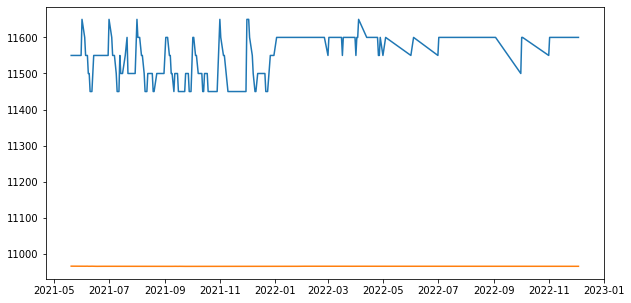

In [57]:
prediction2 = forecast_predict(model2, test_beras_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_beras2 = pd.DataFrame()
data_new_beras2['actual'] = x_test
data_new_beras2['prediction'] = data_result2
data_new_beras2.to_csv('beras_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras2.actual)
plt.plot(y_test, data_new_beras2.prediction)
data_new_beras2

#### Type2

In [58]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 7ms/step - loss: 0.1007 - mae: 0.3114 - val_loss: 0.1729 - val_mae: 0.3815
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.1001 - mae: 0.3104 - val_loss: 0.1722 - val_mae: 0.3808
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0995 - mae: 0.3095 - val_loss: 0.1715 - val_mae: 0.3801
Epoch 4/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0990 - mae: 0.3087 - val_loss: 0.1708 - val_mae: 0.3793
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0984 - mae: 0.3077 - val_loss: 0.1702 - val_mae: 0.3786
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0979 - mae: 0.3069 - val_loss: 0.1695 - val_mae: 0.3779
Epoch 7/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0973 - mae: 0.3060 - val_loss: 0.1688 - val_mae: 0.3772
Epoch 8/50
718/718 [==============================] - 5s 7ms/step - loss: 0.

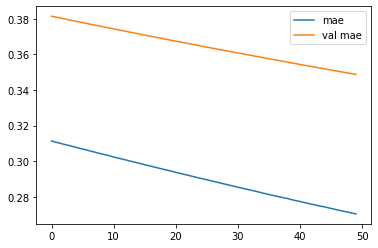

In [59]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [60]:
prediction2_1 = forecast_predict(model2, test_beras_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_beras2_1 = pd.DataFrame()
data_new_beras2_1['actual'] = x_test
data_new_beras2_1['prediction'] = data_result2_1
data_new_beras2_1.to_csv('beras_medium2_model3_sgd_type2.csv')

data_new_beras2

199/199 [==============================] - 1s 4ms/step
478.78186 4.1462984 482.534908063655


,actual,prediction
0,11550,10966.203125
1,11550,10966.178711
2,11550,10966.284180
3,11550,10966.101562
4,11550,10966.174805
...,...,...
229,11600,10965.848633
230,11600,10965.927734
231,11600,10965.889648
232,11600,10965.861328


#### Type 3

In [61]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0690 - mae: 0.2581 - val_loss: 0.1429 - val_mae: 0.3487
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0690 - mae: 0.2581 - val_loss: 0.1429 - val_mae: 0.3487
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0690 - mae: 0.2580 - val_loss: 0.1428 - val_mae: 0.3486
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0689 - mae: 0.2579 - val_loss: 0.1427 - val_mae: 0.3485
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0689 - mae: 0.2578 - val_loss: 0.1427 - val_mae: 0.3485
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0688 - mae: 0.2577 - val_loss: 0.1426 - val_mae: 0.3484
Epoch 7/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0688 - mae: 0.2577 - val_loss: 0.1426 - val_mae: 0.3483
Epoch 8/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0687 - m

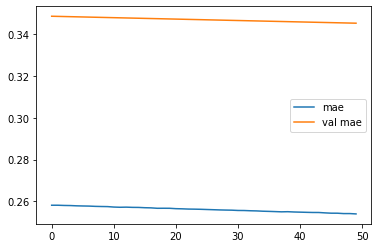

In [62]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [63]:
prediction2_2 = forecast_predict(model2, test_beras_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_beras2_2 = pd.DataFrame()
data_new_beras2_2['actual'] = x_test
data_new_beras2_2['prediction'] = data_result2_2
data_new_beras2_2.to_csv('beras_medium2_model3_sgd-type3.csv')

data_new_beras2_2

181/181 [==============================] - 1s 4ms/step
467.86423 4.0516863 471.70814930950684


,actual,prediction
0,11550,11073.064453
1,11550,11072.984375
2,11550,11072.981445
3,11550,11072.948242
4,11550,11072.974609
...,...,...
229,11600,11072.398438
230,11600,11072.334961
231,11600,11072.338867
232,11600,11072.401367


### Adam

In [64]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [65]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 34ms/step - loss: 0.0689 - mae: 0.2571 - val_loss: 0.0708 - val_mae: 0.2462
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0047 - mae: 0.0498 - val_loss: 0.0355 - val_mae: 0.1624
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 7.3011e-04 - mae: 0.0217 - val_loss: 0.0335 - val_mae: 0.1538
Epoch 4/50
44/44 [==============================] - 1s 14ms/step - loss: 7.6492e-04 - mae: 0.0224 - val_loss: 0.0328 - val_mae: 0.1512
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 5.8555e-04 - mae: 0.0199 - val_loss: 0.0337 - val_mae: 0.1546
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 7.3977e-04 - mae: 0.0219 - val_loss: 0.0329 - val_mae: 0.1515
Epoch 7/50
44/44 [==============================] - 1s 15ms/step - loss: 6.5850e-04 - mae: 0.0212 - val_loss: 0.0326 - val_mae: 0.1503
Epoch 8/50
44/44 [==============================] - 1s 15ms/ste

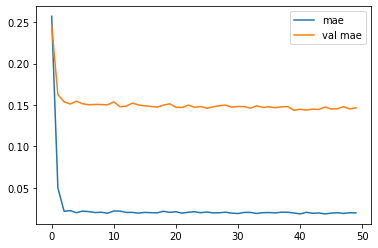

In [66]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [67]:
prediction2_a = forecast_predict(model2_a, test_beras_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_beras2_a = pd.DataFrame()
data_new_beras2_a['actual'] = x_test
data_new_beras2_a['prediction'] = data_result2_a
data_new_beras2_a.to_csv('beras_medium2_model3_adam-type1.csv')

data_new_beras2_a

131/131 [==============================] - 1s 6ms/step
82.07626 0.71381116 101.46281165253356


,actual,prediction
0,11550,11661.481445
1,11550,11659.135742
2,11550,11659.197266
3,11550,11660.348633
4,11550,11660.620117
...,...,...
229,11600,11624.873047
230,11600,11624.048828
231,11600,11624.465820
232,11600,11625.327148


#### Type 2

In [68]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0042 - mae: 0.0412 - val_loss: 0.0313 - val_mae: 0.1443
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0037 - mae: 0.0394 - val_loss: 0.0314 - val_mae: 0.1442
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0036 - mae: 0.0388 - val_loss: 0.0339 - val_mae: 0.1560
Epoch 4/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0035 - mae: 0.0385 - val_loss: 0.0339 - val_mae: 0.1560
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0034 - mae: 0.0374 - val_loss: 0.0336 - val_mae: 0.1544
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0034 - mae: 0.0371 - val_loss: 0.0342 - val_mae: 0.1574
Epoch 7/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0033 - mae: 0.0365 - val_loss: 0.0355 - val_mae: 0.1633
Epoch 8/50
718/718 [==============================] - 5s 7ms/step - loss: 0.

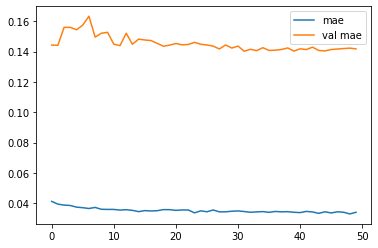

In [69]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
150.25426 1.3044889 159.8618177716305


,actual,prediction
0,11550,11702.845703
1,11550,11700.380859
2,11550,11698.963867
3,11550,11699.297852
4,11550,11701.042969
...,...,...
229,11600,11693.083984
230,11600,11691.259766
231,11600,11691.664062
232,11600,11692.744141


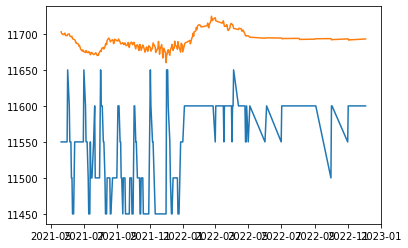

In [70]:
prediction2_a1 = forecast_predict(model2_a, test_beras_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_beras2_a1 = pd.DataFrame()
data_new_beras2_a1['actual'] = x_test
data_new_beras2_a1['prediction'] = data_result2_a1
data_new_beras2_a1.to_csv('beras_medium2_model3_adam-type2.csv')

plt.plot(y_test, data_new_beras2_a1.actual)
plt.plot(y_test, data_new_beras2_a1.prediction)
data_new_beras2_a1

#### Type 3

In [71]:
history2_a2 = model2_a.fit(train_step2, epochs= 100, validation_data=val_step)

Epoch 1/100
84/84 [==============================] - 1s 13ms/step - loss: 0.0024 - mae: 0.0257 - val_loss: 0.0303 - val_mae: 0.1427
Epoch 2/100
84/84 [==============================] - 1s 12ms/step - loss: 0.0024 - mae: 0.0249 - val_loss: 0.0302 - val_mae: 0.1425
Epoch 3/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0024 - mae: 0.0250 - val_loss: 0.0304 - val_mae: 0.1428
Epoch 4/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0024 - mae: 0.0244 - val_loss: 0.0296 - val_mae: 0.1413
Epoch 5/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0024 - mae: 0.0252 - val_loss: 0.0292 - val_mae: 0.1405
Epoch 6/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0024 - mae: 0.0249 - val_loss: 0.0294 - val_mae: 0.1411
Epoch 7/100
84/84 [==============================] - 1s 11ms/step - loss: 0.0024 - mae: 0.0248 - val_loss: 0.0295 - val_mae: 0.1412
Epoch 8/100
84/84 [==============================] - 1s 12ms/step - loss: 0.

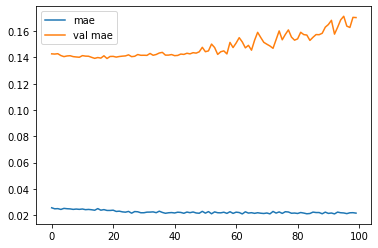

In [72]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

191/191 [==============================] - 1s 4ms/step
69.015015 0.599071 80.48201347001391


,actual,prediction
0,11550,11667.321289
1,11550,11662.549805
2,11550,11661.765625
3,11550,11661.618164
4,11550,11666.692383
...,...,...
229,11600,11654.314453
230,11600,11650.921875
231,11600,11647.627930
232,11600,11649.369141


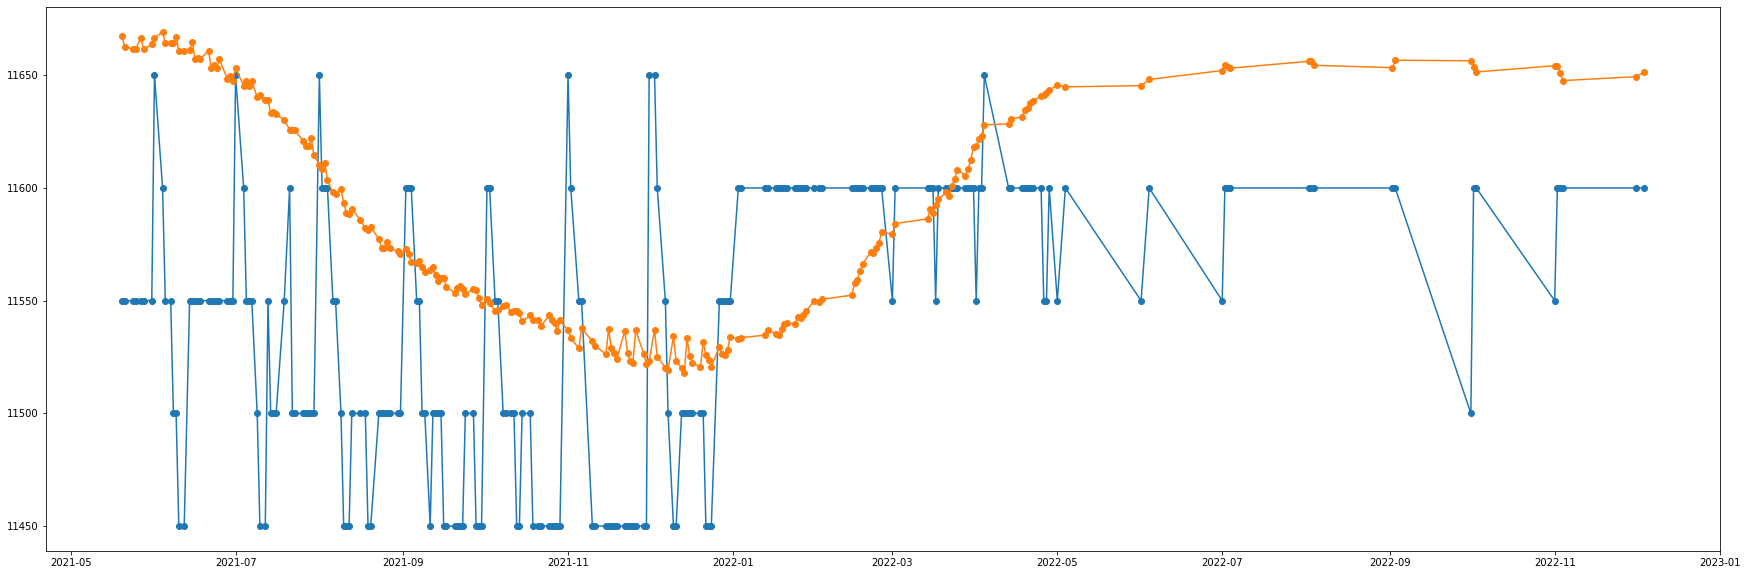

In [73]:
win_size = 100
prediction2_a2 = forecast_predict(model2_a, test_beras_, time_size=win_size, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_beras2_a2 = pd.DataFrame()
data_new_beras2_a2['actual'] = x_test
data_new_beras2_a2['prediction'] = data_result2_a2
data_new_beras2_a2.to_csv('beras_medium2_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_beras2_a2.actual, '-o')
plt.plot(y_test,data_new_beras2_a2.prediction, '-o')
data_new_beras2_a2